In [1]:
import cv2

import numpy as np

from keras import Model, Input

from keras.preprocessing import image

from keras.wrappers.scikit_learn import KerasRegressor

from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D

from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn import metrics
import glob

import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt

from google.colab import drive

In [ ]:
drive.mount('/content/drive')

In [2]:
filenames= glob.glob('/content/drive/My Drive/lfw/*/*.jpg')

In [3]:
all_imgs = []
# Load image files and Resize (h,w,ch) -> h = w < 100 , ch = 3 (R,G,B)
for file in filenames:
    img = image.load_img(file, target_size=(80,80), interpolation="nearest")

    # convert the image to an array

    img = image.img_to_array(img)

    # Normalized color image

    img = img/255

    all_imgs.append(img)

print(all_imgs)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [4]:
all_images = np.array(all_imgs)

print(all_images.shape)

(3203, 80, 80, 3)


In [5]:
train_x, test_x = train_test_split(all_images, random_state=32, test_size=0.3)

train_x, val_x = train_test_split(train_x, random_state=32, test_size=0.3)

Text(0.5, 1.0, 'test_x')

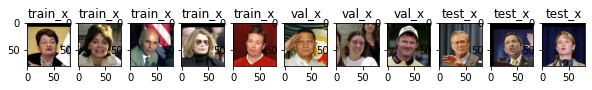

In [6]:
plt.figure(figsize=(10,4))
plt.subplot(1,11,1)
plt.imshow(train_x[0])
plt.title('train_x')
plt.subplot(1,11,2)
plt.imshow(train_x[1])
plt.title('train_x')
plt.subplot(1,11,3)
plt.imshow(train_x[2])
plt.title('train_x')
plt.subplot(1,11,4)
plt.imshow(train_x[3])
plt.title('train_x')
plt.subplot(1,11,5)
plt.imshow(train_x[4])
plt.title('train_x')
plt.subplot(1,11,6)
plt.imshow(val_x[0])
plt.title('val_x')
plt.subplot(1,11,7)
plt.imshow(val_x[1])
plt.title('val_x')
plt.subplot(1,11,8)
plt.imshow(val_x[2])
plt.title('val_x')
plt.subplot(1,11,9)
plt.imshow(test_x[0])
plt.title('test_x')
plt.subplot(1,11,10)
plt.imshow(test_x[1])
plt.title('test_x')
plt.subplot(1,11,11)
plt.imshow(test_x[2])
plt.title('test_x')

In [7]:
# Add Noise
# ก ําหนด noise factor (noise level)
# Add noise
# noise_factor = scalar between 0 -1 ลองอย่ํางน้อย 2 ค่ํา
noise_factor = 0.3
# ก ําหนด noise parameter
# Noise distribution: normal
# Noise mean: zero mean (Nmean = 0)
Nmean = 0
# Noise std: unit variance (Nstd = 1)
Nstd = 1
# use np.random.normal to generate normal distribution (gaussian) noise
x_train_noisy = train_x + (noise_factor * np.random.normal(loc=Nmean, scale=Nstd, size=train_x.shape) )
x_val_noisy = val_x + ( noise_factor * np.random.normal(loc=Nmean, scale=Nstd, size=val_x.shape) )
x_test_noisy = test_x + ( noise_factor * np.random.normal(loc=Nmean, scale=Nstd, size=test_x.shape) )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Text(0.5, 1.0, 'val_x')

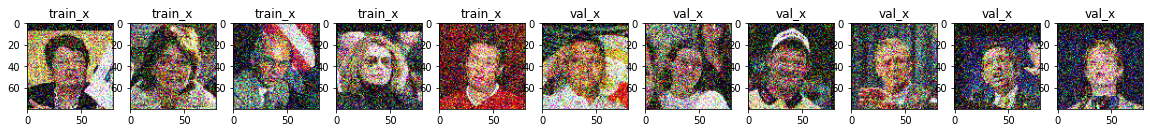

In [8]:
plt.figure(figsize=(20,8))
plt.subplot(1,11,1)
plt.imshow(x_train_noisy[0])
plt.title('train_x')
plt.subplot(1,11,2)
plt.imshow(x_train_noisy[1])
plt.title('train_x')
plt.subplot(1,11,3)
plt.imshow(x_train_noisy[2])
plt.title('train_x')
plt.subplot(1,11,4)
plt.imshow(x_train_noisy[3])
plt.title('train_x')
plt.subplot(1,11,5)
plt.imshow(x_train_noisy[4])
plt.title('train_x')
plt.subplot(1,11,6)
plt.imshow(x_val_noisy[0])
plt.title('val_x')
plt.subplot(1,11,7)
plt.imshow(x_val_noisy[1])
plt.title('val_x')
plt.subplot(1,11,8)
plt.imshow(x_val_noisy[2])
plt.title('val_x')
plt.subplot(1,11,9)
plt.imshow(x_test_noisy[0])
plt.title('val_x')
plt.subplot(1,11,10)
plt.imshow(x_test_noisy[1])
plt.title('val_x')
plt.subplot(1,11,11)
plt.imshow(x_test_noisy[2])
plt.title('val_x')

In [9]:
def create_model(optimizer='adam'):
    Input_img = Input(shape=(80, 80, 3))
    # encoder layers
    #encoding architecture
    x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(Input_img)
    x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x1)
    x2 = MaxPool2D( (2, 2))(x2)
    encoded = Conv2D(64, (3, 3), activation='relu', padding='same')(x2)
    # decoding architecture
    x3 = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
    x3 = UpSampling2D((2, 2))(x3)
    x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x3)
    x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(x2)
    decoded = Conv2D(3, (3, 3), padding='same')(x1)
    # construct the autoencoder model
    autoencoder = Model(Input_img, decoded)
    autoencoder.compile(optimizer=optimizer, loss='mean_squared_error',metrics=['mean_squared_error'])
    return autoencoder

In [10]:
# ประกาศ KERAS ตัวจัดกําหนดพารามิเตอร์ของ Model
model = KerasRegressor(build_fn=create_model, epochs=2, batch_size=16, verbose=0)

In [11]:
optimizer = ['SGD', 'RMSprop', 'Adadelta', 'Adam']
batch_size = [8, 16, 32]
epochs = [2,4,6]
param_grid = dict(batch_size=batch_size, epochs=epochs, optimizer=optimizer)

In [12]:
grid = GridSearchCV( estimator=model,
n_jobs = -1,
verbose= 0,
cv=2,
param_grid = param_grid,)

In [ ]:
grid_result = grid.fit(x_train_noisy, train_x)

In [ ]:
print('Best params: ',grid_result.best_params_)
print('Best score: ', grid_result.best_score_)

In [ ]:
means = grid_result.cv_results_['mean_test_score']

stds = grid_result.cv_results_['std_test_score']

params = grid_result.cv_results_['params']

In [ ]:
plt.plot(means, label='means')
plt.plot(stds, label='stds')
plt.legend(loc='best')
plt.show()

In [ ]:
random_search = {'optimizer': ['SGD', 'RMSprop', 'Adadelta', 'Adam'],
'batch_size': list(np.linspace(8, 64, 5, dtype = int)),
'epochs': list(np.linspace(1, 10, 4, dtype = int))}

In [ ]:
grid_rand = RandomizedSearchCV( estimator=model,
n_jobs = 1,
verbose= 0,
cv=2,
random_state = 10,
n_iter = 10, # จ ํานวน random parameters
param_distributions = random_search)

In [ ]:
grid_rand_result = grid_rand.fit(x_train_noisy, train_x)

In [ ]:
print('Best params: ',grid_rand_result.best_params_)
print('Best score: ', grid_rand_result.best_score_)

In [ ]:
means = grid_result.cv_results_['mean_test_score']

stds = grid_result.cv_results_['std_test_score']

params = grid_result.cv_results_['params']

In [ ]:
plt.plot(means, label='means')
plt.plot(stds, label='stds')
plt.legend(loc='best')
plt.show()